In [1]:
import deepxde as dde
import numpy as np
from deepxde.backend import pytorch
import torch
import matplotlib.pyplot as plt
from SIRD_deepxde_class import SIRD_deepxde_net
from SIRD_deepxde_class import Plot

Using backend: pytorch



# Create synthetic data

In [2]:
alpha_real = 0.2
beta_real = 0.05
gamma_real = 0.01

total  [2.04643018e+05 1.47928048e+03 3.99489808e+06 7.98979617e+05]
total  5000000.000000002


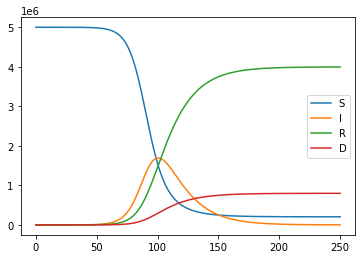

In [3]:
import ODE_SIR
solver = ODE_SIR.ODESolver()
t_synth, wsol_synth, N = solver.solve_SIRD(alpha_real, beta_real, gamma_real)
solver.plot_SIRD(t_synth, wsol_synth)

Use cell below if we want to subset timestep - ie simulate if we are at an early stage in the pandemic so have limited data

In [4]:
# keep this even if not subsetting
t = t_synth
wsol = wsol_synth

# subset
max_timestep = 100
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

# Create model
Code has been wrapped in a custom class that wraps around the deepxde model

In [5]:
model = SIRD_deepxde_net(t, wsol)

In [6]:
model.init_model(print_every=1000)

Compiling model...
'compile' took 0.000135 s



In [7]:
model.train_model(iterations=10000)

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [1.05e-03, 1.38e-02, 2.99e-03, 2.59e-03, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 1.38e+00, 3.02e-01, 2.68e-01, 9.73e-02]    [1.05e-03, 1.38e-02, 2.99e-03, 2.59e-03, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 1.38e+00, 3.02e-01, 2.68e-01, 9.73e-02]    []  
0 [1.00e-01, 1.00e-01, 1.00e-01]
1000      [2.49e-05, 9.25e-06, 1.54e-06, 5.88e-06, 4.19e-05, 4.55e-05, 1.10e-03, 8.79e-04, 2.02e-02, 6.61e-03, 6.07e-03, 3.75e-03]    [2.49e-05, 9.25e-06, 1.54e-06, 5.88e-06, 4.19e-05, 4.55e-05, 1.10e-03, 8.79e-04, 2.02e-02, 6.61e-03, 6.07e-03, 3.75e-03]    []  
1000 [3.89e-02, 1.58e-02, 5.29e-03]
2000      [4.07e-06, 2.42e-06, 4.81e-06, 1.05e-06, 1.76e-08, 5.04e-07, 1.80e-09, 5.93e-08, 4.19e-04, 1.54e-04, 1.50e

# Investigate output
First use the predicted parameters from the neural network to solve the ODE

In [8]:
alpha_nn, beta_nn, gamma_nn = model.get_predicted_params()
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)

In [9]:
# we need to set the synthetic data as it comes from outside the network
# the two functions below sets the synthetic data
model.set_synthetic_data(t_synth, wsol_synth) 
model.set_nn_synthetic_data(t_nn_param, wsol_nn_param)

In [10]:
plot = Plot(model) # class that contains plotting functions

The plots below show two things:  
* A comparison between the data we have and what the PINN predicts in this range
* A comparison between the synthetic data in the whole range and the result from using the predicted parameters in the ODE solver

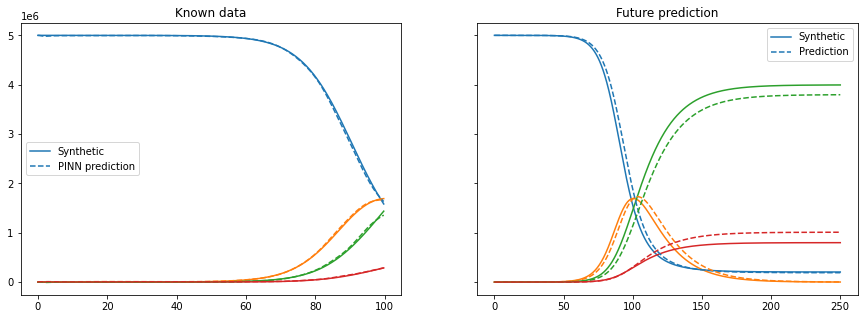

In [11]:
plot.show_known_and_prediction()

# Same as before with even less data
The timing of the data is important. We want to predict as early as possible in the pandemic, so investigate what the effect is of having less data.

In [17]:
max_timestep = 85
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

In [18]:
model_less = SIRD_deepxde_net(t, wsol)
model_less.init_model(print_every=1000)
model_less.train_model(iterations=10000)

Compiling model...
'compile' took 0.000129 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [3.85e-03, 1.00e-02, 1.62e-03, 5.30e-04, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 2.78e+00, 7.64e-02, 1.88e-01, 2.22e-01]    [3.85e-03, 1.00e-02, 1.62e-03, 5.30e-04, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 2.78e+00, 7.64e-02, 1.88e-01, 2.22e-01]    []  
0 [1.00e-01, 1.00e-01, 1.00e-01]
1000      [1.00e-05, 1.60e-05, 4.92e-07, 7.36e-07, 1.35e-03, 5.49e-04, 1.92e-04, 9.42e-05, 3.71e-03, 1.74e-03, 5.25e-04, 2.31e-05]    [1.00e-05, 1.60e-05, 4.92e-07, 7.36e-07, 1.35e-03, 5.49e-04, 1.92e-04, 9.42e-05, 3.71e-03, 1.74e-03, 5.25e-04, 2.31e-05]    []  
1000 [4.53e-02, 1.24e-02, 3.97e-03]
2000      [2.54e-06, 1.18e-06, 2.75e-07, 2.39e-07, 4.30e-06, 1.60e-05,

In [19]:
alpha_nn, beta_nn, gamma_nn = model_less.get_predicted_params()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)

Alpha: 0.15786223113536835, beta: 0.03658798709511757, gamma: 0.007921840995550156


In [20]:
model_less.set_synthetic_data(t_synth, wsol_synth)
model_less.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_less = Plot(model_less)

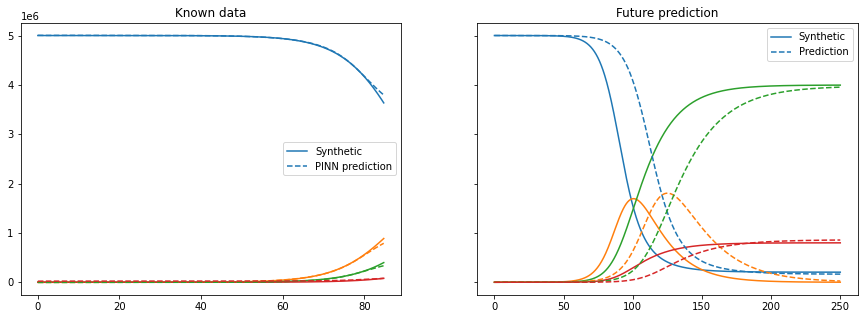

In [21]:
plot_less.show_known_and_prediction()